In [2]:
import h5py
import numpy as np
import matplotlib

# loading customized matplotlib style. If not available, it does nothing
try:
    matplotlib.rcParams = matplotlib.rc_params_from_file("/swissfel/photonics/sala/sacla/utilities/matplotlibrc")
except:
    pass

# using the NBAgg backend, which allows interactive plots in the Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

DIR = "/swissfel/photonics/data/TestData/XPP/FEE_Spectrometer/"

## Spectrometers

If you look at both the FEE and the OPAL spectrometers, it seems clear that the energy calibrations which are provided with the MATLAB script are not coherent (which one is wrong I don't know). Also, I have no clue why the FEE and the OPAL are time-shifted **(is the FEE always skipping the first 15 events?)**


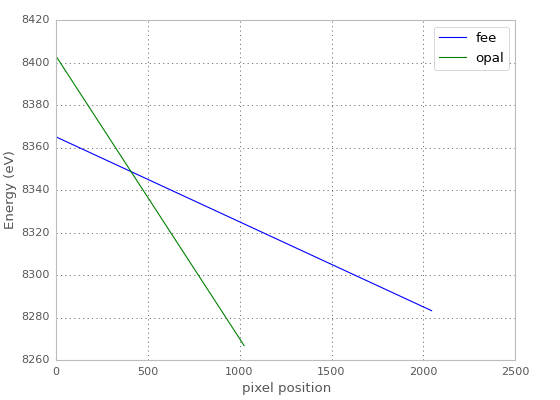


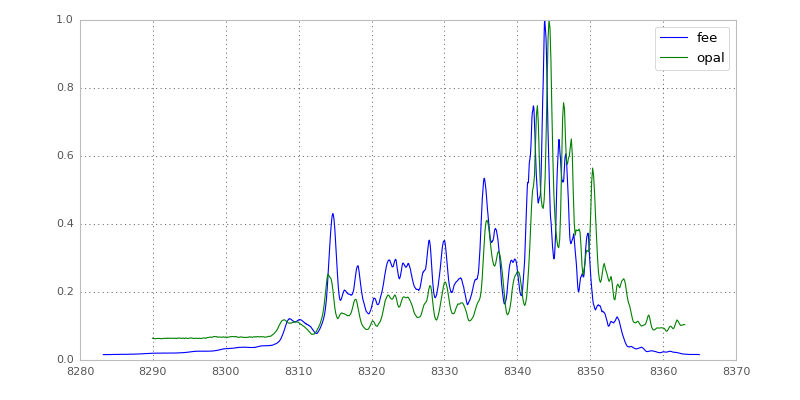

In [3]:
# file
f = h5py.File(DIR + "xppc0114-r0270.h5", "r")

# Main dataset for FEE / OPAL cameras
dset_c = 'Configure:0000/Run:0000/CalibCycle:0000/Camera::FrameV1'

# Name of OPAL and FEE datasets
opal_name = "/XppEndstation.0:Opal1000.0"
fee_name = "/XrayTransportDiagnostic.0:Opal1000.0"

tag_idx = 300  # array position to look at
offset = 15  # time offset between OPAL and FEE (???)
fee = f[dset_c + fee_name]["image"][tag_idx - offset]
opal = f[dset_c + opal_name]["image"][tag_idx][450:600, ]  # ROI as specified in MATLAB file

# energy calibrations
fee_energy = 8365. - 0.04 * np.arange(1, fee.shape[1] + 1)
opal_energy = 8403. - 0.133 * np.arange(1, opal.shape[1] + 1)

# plots
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, fee.shape[1] + 1), fee_energy, label="fee")
plt.plot(np.arange(1, opal.shape[1] + 1), opal_energy, label="opal")
plt.xlabel("pixel position")
plt.ylabel("Energy (eV)")
plt.legend(loc="best")

plt.figure(figsize=(10, 5))
plt.plot(fee_energy, fee.sum(axis=0) / fee.sum(axis=0).max().astype(float), label="fee")
x_min = 300 
x_max = 850
plt.plot(opal_energy[x_min:x_max], opal[:, x_min:x_max].sum(axis=0) / opal[:, x_min:x_max].sum(axis=0).max().astype(float), label="opal")
plt.legend(loc="best")

plt.show()

Slightly changing the OPAL calibration improves a lot, for example:


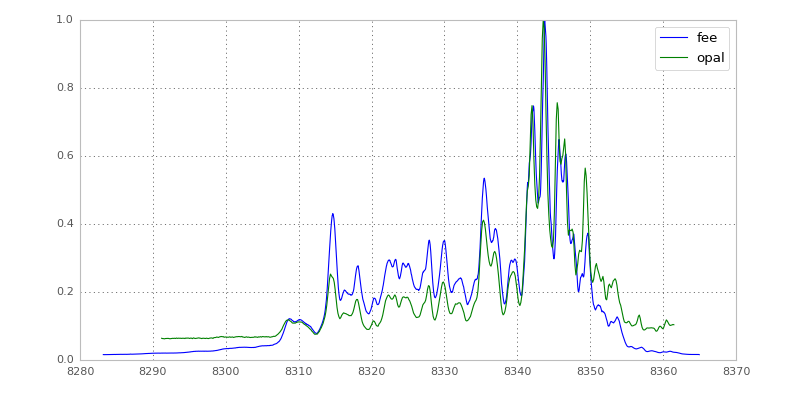

In [4]:
opal_energy_2 = 8400. - 0.128 * np.arange(1, 1025)

plt.figure(figsize=(10, 5))
plt.plot(fee_energy, fee.sum(axis=0) / fee.sum(axis=0).max().astype(float), label="fee")
x_min = 300 
x_max = 850
plt.plot(opal_energy_2[x_min:x_max], opal[:, x_min:x_max].sum(axis=0) / opal[:, x_min:x_max].sum(axis=0).max().astype(float), label="opal")
plt.legend(loc="best")

plt.show()

## Pulse id / timestamps?

I still have no clue on how to retrieve the correct global timestamp, or the pulse-id. In the HDF5 file there is a `time` dataset for each device, with various fields:

In [5]:
fee_time = f[dset_c + fee_name + "/time"]
fee_time.dtype

dtype([('seconds', '<u4'), ('nanoseconds', '<u4'), ('ticks', '<u4'), ('fiducials', '<u4'), ('control', '<u4'), ('vector', '<u4')])

`seconds` are possibly 

> seconds from 1990

while my last knowledge of `nanoseconds` was:

> nanoseconds with least significant 17 bits encoded as pulse id

`fiducials` is not clear... it seems is connected to the 360 Hz event generation system, and actually here grows 3 by three:

In [6]:
fee_time["fiducials"][0:10]

array([112674, 112677, 112680, 112683, 112686, 112689, 112692, 112695,
       112698, 112701], dtype=uint32)

### Issues
    
First of all, by eye `nanoseconds` seem to have the pulseid information in the most significant bits, and not the least    

In [7]:
print fee_time["nanoseconds"][0:100]
print np.trunc(fee_time["nanoseconds"][0:100] * 1e-7)

[254475799 262795013 271222689 279416818 287807618 296026610 304418108
 312819733 321190768 329469125 337831221 346167405 354492276 362816796
 371216466 379468493 387815643 396222437 404486825 412789556 421237276
 429450191 437812636 446256865 454542624 462830200 471228543 479338374
 487824158 496301908 504521040 512868749 521246768 529507525 537832535
 546268243 554506022 562890396 571310320 579462125 587882258 596275503
 604497428 612801975 621173708 629412465 637840770 646278642 654492746
 662799946 671240753 679500462 687873033 696288696 704490158 712805810
 721239841 729500668 737805774 746195037 754541418 762853507 771245076
 779510023 787871490 796229046 804482959 812811042 821205054 829534534
 837877773 846191957 854549444 862785477 871197299 879515115 887920302
 896207459 904559288 912839740 921225581 929576083 937857234 946266890
 954581494 962911253 971160905 979569445 987901370 996286233   4566057
  12867460  21231581  29569442  37889354  46204796  54625627  62822899
  7118

Sounds cool, but there are **repeated numbers** (every "7"):


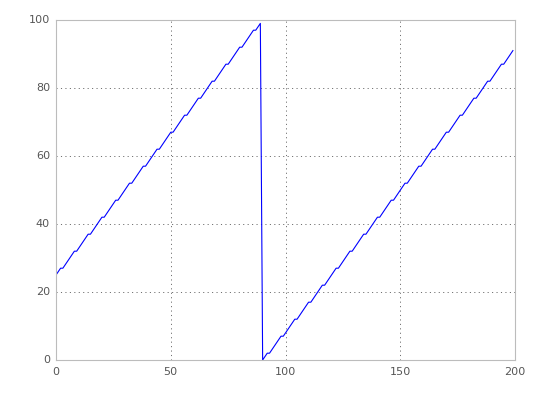

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(np.trunc(fee_time["nanoseconds"][0:200] * 1e-7))
plt.show()

Rounding does not help, either:


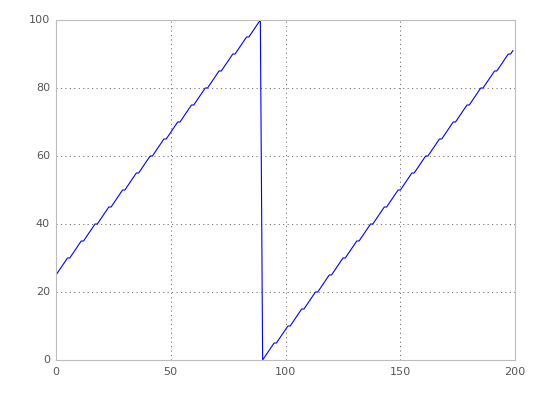

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(np.round(fee_time["nanoseconds"][0:200] * 1e-7))
plt.show()

doing binary algebra seems not to help either:

In [10]:
ta = fee_time['nanoseconds'][0]
tb = fee_time['nanoseconds'][1]

print "two consecutive events"
print ta, tb
print "\ntwo consecutive events, 17 LSB"
print ta & 0x1ffff, tb & 0x1ffff

two consecutive events
254475799 262795013

two consecutive events, 17 LSB
65047 126725


`Fiducials` seems not bad...


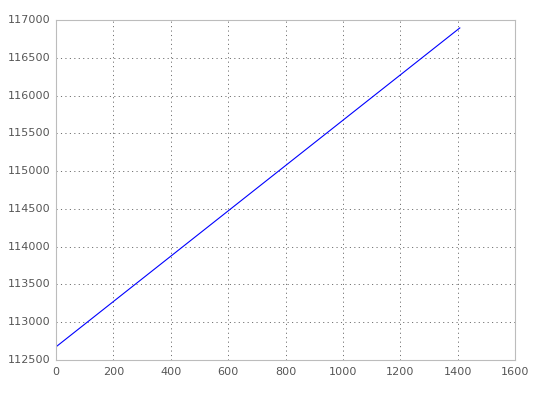

In [11]:
plt.figure(figsize=(7, 5))
plt.plot(fee_time["fiducials"])
plt.show()

Fiducials run 360 Hz... so let's check shift between FEE and OPAL:

In [12]:
opal_time = f[dset_c + opal_name + "/time"]
print (fee_time["fiducials"][:10] - opal_time["fiducials"][:10]) / 3


[15 15 15 15 15 15 15 15 15 15]


Cool, at least we got the 15 events shift. But not clear if we should use *fiducials* or not.

**So, any idea how to get the correct time / pulse-id?**

In [21]:
opal2 = f[dset_c + opal_name]["image"][:].sum(axis=1)
print opal2.shape
print np.linalg.matrix_rank(opal2)

(1386, 1024)
1024
